In [1]:
!pip install hdbscan
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=3584970 sha256=fb0a080b7078c7523daaa624b4fd4873ddc2a92686f08e4f09d78b3d54e990db
  Stored in directory: /root/.cache/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan


In [2]:
import hdbscan
import pandas as pd
import numpy as np
#%matplotlib ipympl
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')
# sys.path.append('/notebooks/Beta-VAE/')
from models import*

from src.band_plotters import*
from src.Tiff32Image import*
from src.TensorImageNoised import *

sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *

from ae_misc import *

In [3]:
FINGERPRINT_LENGTH = 98

#FINGERPRINT_NAME = "functional_10dpi_bernoulli_VAE_L={0}".format(FINGERPRINT_LENGTH)
FINGERPRINT_NAME = "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH)
#FINGERPRINT_NAME = "all_k_branches_histogram_-8_to_8".format(FINGERPRINT_LENGTH)
#FINGERPRINT_NAME = "128x128_random_erase_resnet18_VAE_L={0}".format(FINGERPRINT_LENGTH)

PERPLEXITY = 30
FLAT_ONLY = False
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [4]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,1.800380,1.783413,1.751181,1.657435,1.699241,1.757099,1.648585,1.750903,80.652300,33.975147
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,2.065734,1.790841,1.797779,1.940001,1.778363,1.646309,1.777840,1.804859,-102.511086,76.040360
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,2.325100,1.733577,1.816098,1.953408,1.904952,1.718350,1.920829,1.940830,-17.031164,-22.583645
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,2.374648,2.153072,2.535491,1.912330,2.053569,2.283617,2.490727,2.131947,-74.647250,38.610275
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,2.629308,2.182670,2.361369,2.758861,2.421932,2.233414,2.194449,2.162071,74.347855,47.444942


In [13]:
df[df.formula=="InCl3"]

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-793,InCl3,AB3,51,4,3,0.67722,bottom-up,0,0,0.039820,...,2.762192,2.496476,2.675884,2.202883,1.941190,1.951558,2.287760,2.850394,129.71290,-40.372265
2dm-1632,InCl3,AB3,12,3,3,0.84803,bottom-up,1,3,0.068652,...,2.266140,2.300384,1.943068,2.677186,1.731903,1.935121,2.743174,2.179523,179.75410,-57.404125
2dm-2774,InCl3,AB3,6,4,4,0.78167,bottom-up,1,3,NaN,...,2.565874,2.503097,2.764257,2.561031,2.519273,2.082989,1.816090,1.967047,126.10002,-63.191017


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


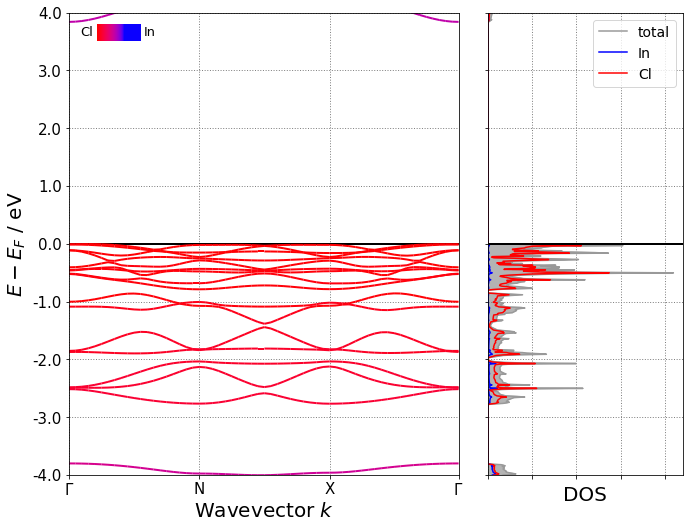

ValueError: x and y must have same first dimension, but have shapes (98,) and (60,)

<Figure size 432x288 with 0 Axes>

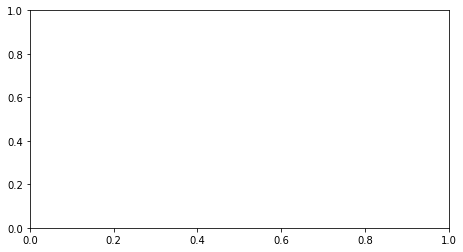

In [14]:
N_segs = 3
index = '2dm-1632'
plot(index)
plt.savefig("report pseudo flow diagram_2")
plt.figure(figsize=(7.5,4))
plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
# # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
# ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
plt.xlabel("[-8,8]eV energy segments")
for i in range(0, N_segs+1):    
    plt.plot(np.zeros(N_segs)+i*np.ones(N_segs)*(FINGERPRINT_LENGTH/N_segs), [0,0, 190], linestyle="dashed", c='b')
    
plt.xticks(np.arange(0, 60, step=20), labels=["                         segment_1","                          segment_2","                         segment_3"])
plt.title("pseudo-D.o.S. fingerprint")
plt.savefig("report pseudo flow diagram")
plt.show()

## Cluster

In [5]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [8]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=6, min_samples=2, p=0.2, cluster_selection_epsilon=0.0)
#clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
clusterer.fit(df[fingerprint_cols])


df["labels"] = clusterer.labels_


In [9]:
#import sys
from sklearn import manifold
from sklearn import decomposition
from sklearn import metrics
from functools import partial
import hdbscan
#from s_dbw import S_Dbw
#from internal_validation import internalIndex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas
import networkx as nx
#import seaborn as sns
#from scipy.spatial.distance import euclidean
from matplotlib.colors import LinearSegmentedColormap
from ete3 import Tree, TreeStyle
print ('import_complete')


import_complete


In [10]:
###################################
####  HDBSCAN
MS=6
SS=2

        
# fname='HDBSCAN_244_DOS_minsize_'+str(min_size)+'_minsamp_'+str(min_samp)
# f = open(fname+'_summary_india.txt', 'w')
# f.write('Minkowski_metric_p=0.2\n')
# f.write('Total#sample   Min_size   Min_samples   N_clusters   N_noise  Max_persistence  Avg_persistence \
#         Max_Lambda_in_bar  Max_cluster_size  Silhouette  CH_measure DB_measure DBCV s-dbw \n')  

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=3, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=4, min_samples=2, p=0.2, cluster_selection_epsilon=0.0)
#clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
db = clusterer.fit(df[fingerprint_cols])
labels = db.labels_


#################
#### plot objects
cond_tree=db.condensed_tree_
plot_obj=cond_tree.get_plot_data()
#single_link_tree=db.single_linkage_tree_

#########################################
############## Colormap
##############################
import matplotlib
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))



################################## 
###### Pandas data
##################################
panda_data=cond_tree.to_pandas()
#print(G.number_of_nodes())
#print(panda_data)
selected_clusters=cond_tree._select_clusters()
G1 = panda_data[panda_data['child_size'] > 1]
#New_Nx=nx.from_pandas_edgelist(G1,'parent','child',['lambda_val', 'child_size'])
#nx.write_edgelist(New_Nx,'New_edgelist', encoding = 'latin-1')



In [11]:
from ete3 import Tree,TreeStyle,NodeStyle


In [13]:
!jupyter nbconvert --to script click_on_material-Copy1.ipynb

[NbConvertApp] Converting notebook click_on_material-Copy1.ipynb to script
[NbConvertApp] Writing 18033 bytes to click_on_material-Copy1.py


In [ ]:
##############################
################ ETE treee from parent child relations
tree = Tree.from_parent_child_table(g1_list)
#tree.write(format=9,outfile='new_tree.nw')
print(G2)
for node in tree.traverse():
    nstyle = NodeStyle()
    if node.is_leaf():
        index1=G2.index[G2['child'] == int(node.name)]
        node.name=G2.at[index1[0],'cluster_id']
        #nstyle = NodeStyle()
        #print(int(node.name))
        #print(matplotlib.colors.rgb2hex(cmap(norm(int(node.name)))))
        nstyle["fgcolor"] = str(matplotlib.colors.rgb2hex(cmap(norm(int(node.name)))))
        #nstyle['fgcolor']='#FF0000'
        nstyle["size"] = G2.at[index1[0],'child_size']/2
    else:
        nstyle["fgcolor"] ='black'
    node.set_style(nstyle)
tree.write(format=1,outfile='new_tree.nw')
#################################
################### Plot
ts = TreeStyle()
ts.mode='c'
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 360
ts.scale = 40
ts.show_leaf_name=True
tree.show(tree_style=ts)

# View cluster for bernoulli auto-encoded fingerprint


In [7]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


bernoulli_input_file_index="no_dos_bw_2/dpi_10"
    
bernoulli_model = BetaVAE_B(z_dim=64, nc=3)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/BW_B_gamma100_z64/last")
bernoulli_model.load_state_dict(checkpoint['model_states']['net'])

bernoulli_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])
    print(num_plots)
    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction_images(index, bernoulli_model, image_directory="../../../storage/2dmatpedia/images/{0}".format(bernoulli_input_file_index), width=64, height=64, height_mode="pad", act_func=F.sigmoid)

#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

NameError: name 'BetaVAE_B' is not defined

In [19]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


VAE_input_file_index="energies4"
    
VAE_model = BetaVAE_B(z_dim=32)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/energies4_B_beta10_z32/last")
VAE_model.load_state_dict(checkpoint['model_states']['net'])

VAE_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction(index, VAE_model, -7, 7, image_directory="energies4", width=64, height=64, height_mode="pad", act_func=F.sigmoid)


#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(111))

/notebooks/Beta-VAE/model.py:191: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


interactive(children=(IntSlider(value=111, description='label', max=333, min=-111), Output()), _dom_classes=('…

<function __main__.view_cluster(label)>

# View cluster for any fingerprint

In [34]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        # ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        #plot(index)

interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=42, description='label', max=86, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

# VIEW cluster for resnet AE or VAE (must change model import below, and the .predict function in view_cluster!)

In [7]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

In [8]:
def bce_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return nn.BCEWithLogitsLoss()(x_recon, targ) + 0.05 * kld_mean_loss(mu, logvar)

In [104]:
# MUST CHANGE FOR DIFFERENT LATENT LENGTH MODEL!
learn = load_learner("../autoencoder/trained_models/resnet18_size128_lossMSE_channels16.pkl")

#model_path = "../autoencoder/trained_models/vae_resnet18_size128_lossbcekl_randerase_channels4.pkl"
#learn = load_learner(model_path)

def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        plot(index)
        plt.show()
        
        # FOR NORMAL AE
        out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        show_image(out[1])
        
        # FOR VAE
        #x_recon, mu, sigma = predict(learn,DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        #show_image(torch.sigmoid(x_recon[0]))
        #x_recon.size()
        
        plt.show()
        
#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=1)

interactive(children=(IntSlider(value=1, description='label', max=3, min=-1), Output()), _dom_classes=('widget…

<function __main__.view_cluster(label)>

In [38]:
df[df.formula=="AsCuLi2"]

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,57,58,59,60,61,62,63,fx,fy,labels
ID,,,,,,,,,,,,,,,,,,,,,


## Rerun TSNE (ONLY IF ON FLAT SUBSET)

In [ ]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=15.0, init="pca",learning_rate="auto", random_state=0, perplexity=5,n_iter=10000, verbose=2, metric="manhattan")
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.000s...
[t-SNE] Computed neighbors for 2005 samples in 0.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 10.163043
[t-SNE] Computed conditional probabilities in 0.030s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 109.4916306, gradient norm = 0.0530031 (50 iterations in 2.671s)
[t-SNE] Iteration 100: error = 116.6260452, gradient norm = 0.0230778 (50 iterations in 1.882s)
[t-SNE] Iteration 150: error = 117.8740234, gradient norm = 0.0033048 (50 iterations in 2.144s)
[t-SNE] Iteration 200: error = 117.9394531, gradient norm = 0.0002687 (50 iterations in 1.383s)
[t-SNE] Iteration 250: error = 117.9427414, gradient norm = 0.0002585 (50 iterations in 2.268s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 117.942741
[t-SNE] Iteration 300: error = 2.9432981, gradient norm = 0.0026912 (50 iterations in 1.870s)
[t-SNE] Iteration 350: error = 2.3561637, gradient norm = 0.0012212 (50 iterations in 2.619s)
[t-SNE] Iteration 400: error = 2.0841274, gradient norm = 0.0007503 (50 iterations in 3.714s)
[t-SNE] Iteration 450: error = 1.9346863, gradient norm = 0.0005263 (50 iterations in 3.461s)
[t-SNE] Iteration 500: error = 1.8432245, gradient norm = 0.000406

## Plots

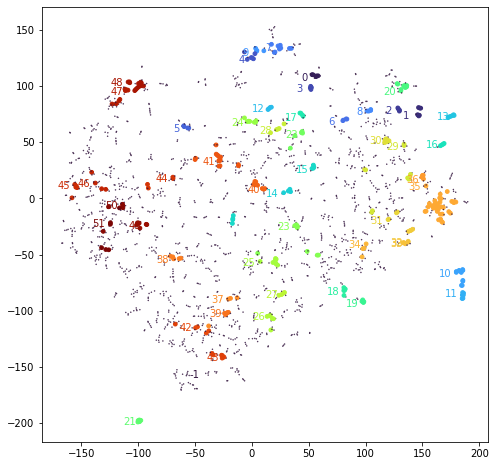

In [11]:
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*14
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-10,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=10).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.show()

Output()

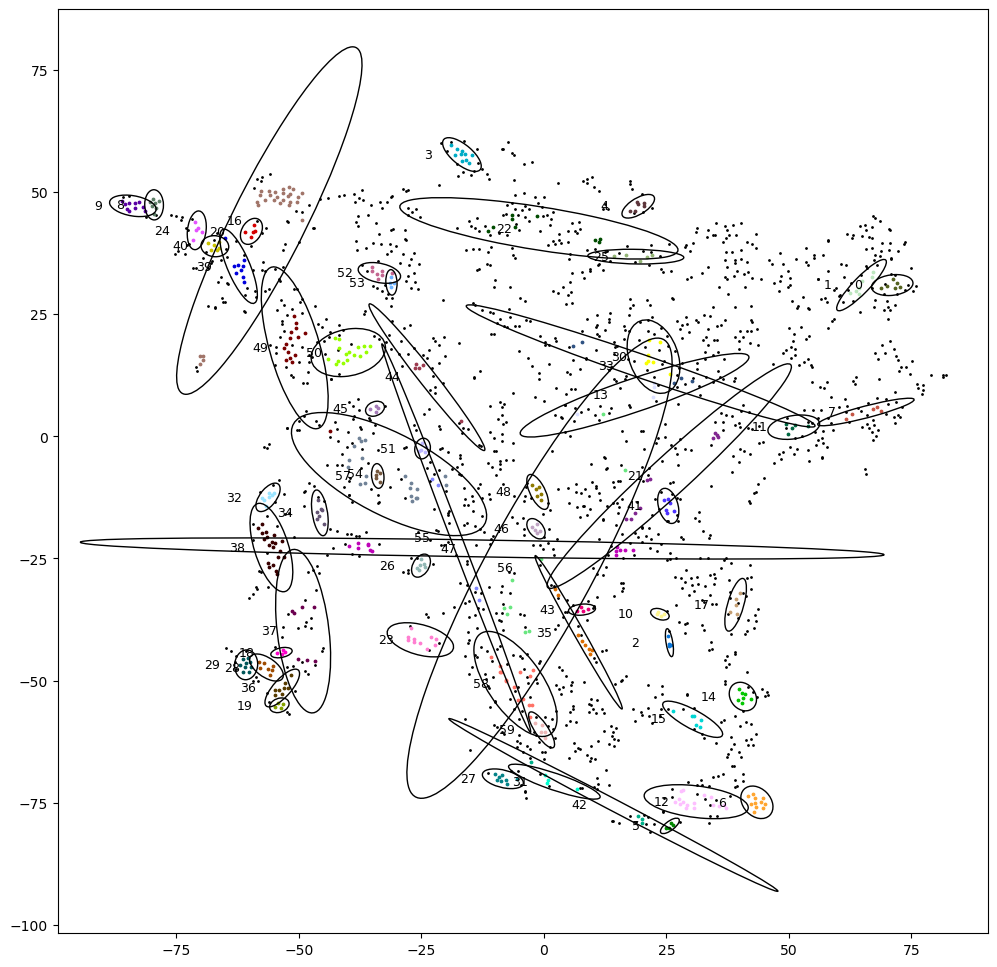

In [17]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Output()

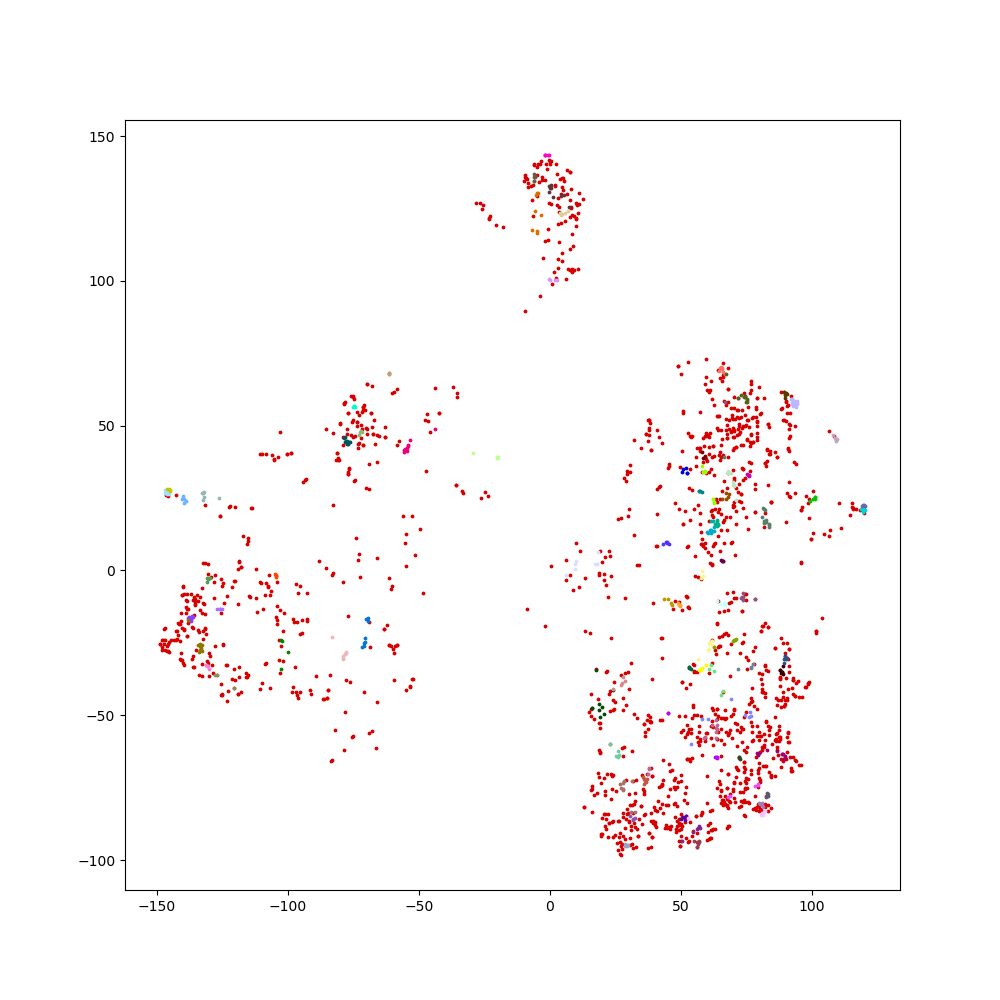

In [12]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plot_groups(df,"labels", ax=ax)
#ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# 2D HISTOGRAM FOR HDBSCAN PARAMETER OPTIMISATION

In [41]:
MS_vals = np.arange(2,12,1)
MCS_vals = np.arange(2,12,1)

DBCV_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_cluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_uncluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))

for i,MS in enumerate(MS_vals):
    for j,MCS in enumerate(MCS_vals):
        #print(MS,MCS)
        #print(i,j)
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                                gen_min_span_tree=True, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=MCS, min_samples=MS, p=0.2)
        #clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
        clusterer.fit(df[fingerprint_cols])

        df["labels"] = clusterer.labels_
        
        DBCV_vals[-(j+1),i] = clusterer.relative_validity_ 
        N_cluster_vals[-(j+1),i] = len(np.unique(clusterer.labels_))-1
        N_uncluster_vals[-(j+1),i] = len(df[df["labels"]==-1])

        

Text(0.5, 1.0, '[[0.07408321 0.05719583 0.02683594 0.02088851 0.0214418  0.01430383\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.0721241  0.05719583 0.03163518 0.02551871 0.0214418  0.02067047\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.07654506 0.06111259 0.03566593 0.02551871 0.0312092  0.02067047\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.07786822 0.06488722 0.03944247 0.03656153 0.03492427 0.02422886\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.09179331 0.07460552 0.04893343 0.03985142 0.03820086 0.03080423\n  0.01911904 0.01781102 0.01064017 0.00635515]\n [0.0778927  0.09393872 0.0545307  0.03516922 0.04101874 0.0363882\n  0.03163183 0.0206466  0.01636958 0.01439212]\n [0.08311159 0.06688069 0.05916007 0.04210127 0.04101874 0.0363882\n  0.03395227 0.02295781 0.02162625 0.01697509]\n [0.07766967 0.07191693 0.05731166 0.04578998 0.04101874 0.0363882\n  0.03395227 0.0266888  0.02162625 0.0206336 ]\n [0.13138373 0.075194   0.06322128 0.0468562  0.046

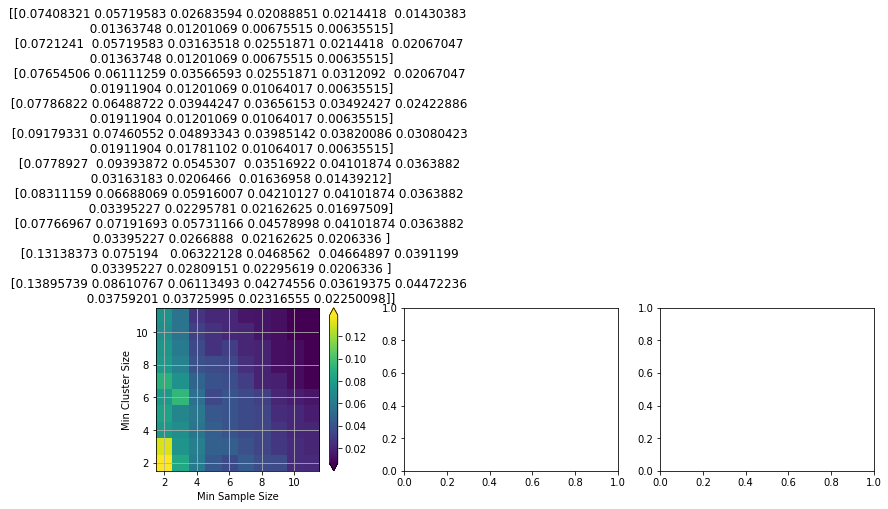

In [55]:
parameter_mesh = np.meshgrid(MS_vals, MCS_vals)
#plt.contourf(MS_vals,MCS_vals,DBCV_vals,5)
#plt.show()
#plt.imshow(DBCV_vals, extent=[2,12,2,12])
names = [DBCV_vals, N_cluster_vals, N_uncluster_vals]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

D = ax1.imshow(name, extent=[1.5,11.5,1.5,11.5])
fig.colorbar(D, ax=ax1, extend='both')

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")

ax1.grid()
ax1.set_title("{0}".format(name))
#plt.show()

#plt.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(DBCV_vals, interpolation='bilinear')

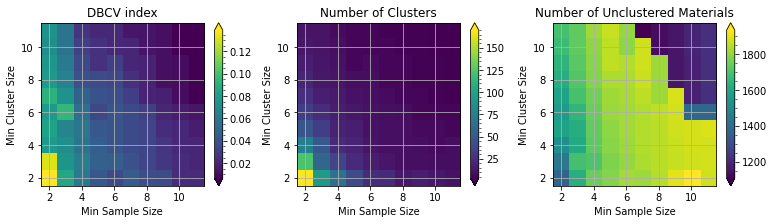

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)


# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar3 = fig.colorbar(pos, ax=ax1, extend='both')

# repeat everything above for the negative data
# you can specify location, anchor and shrink the colorbar
neg = ax2.imshow(N_cluster_vals, extent=[1.5,11.5,1.5,11.5])
cbar2 = fig.colorbar(neg, ax=ax2, extend='both')



# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = ax3.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar1 = fig.colorbar(pos_neg_clipped, ax=ax3, extend='both')
cbar1.minorticks_on()
cbar2.minorticks_on()
cbar3.minorticks_on()

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")
ax1.grid()
ax1.set_title("DBCV index")

ax2.set_xlabel("Min Sample Size")
ax2.set_ylabel("Min Cluster Size")
ax2.grid()
ax2.set_title("Number of Clusters")

ax3.set_xlabel("Min Sample Size")
ax3.set_ylabel("Min Cluster Size")
ax3.grid()
ax3.set_title("Number of Unclustered Materials")

plt.savefig("2d_hist_hdbscan_params", dpi=100, bbox_inches="tight")
plt.show()
